In [ ]:
import os
import glob
import random

import torch
import torchvision
import numpy as np
import cv2
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
import torch.nn.functional as F

from IPython.display import Image

Подключаем cuda

In [ ]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

device

'cuda'

## Датасет

Ссылка на датасет - https://www.kaggle.com/datasets/lantian773030/pokemonclassification

Датасет состоит из изображений покемонов, разделенных на классы.

Всего 150 классов.

Изображения изначально разных размеров, приведем изображения к одному размеру 100 на 100 пикселей

In [ ]:
DATA_PATH = r'D:\ProgrammingPython\neural_networks\PokemonData'
DATA_PATH

'D:\\ProgrammingPython\\neural_networks\\PokemonData'

In [ ]:
classes = {n: cls for n,cls in enumerate(os.listdir(DATA_PATH))}
classes_invert = {value:key for key, value in classes.items() }

In [ ]:
classes_img_stat = {}
for cls in os.listdir(DATA_PATH):
    cls_path = os.path.join(DATA_PATH, cls)
    classes_img_stat[cls] = []
    for img_name in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_name)
        img = cv2.imread(img_path)
        classes_img_stat[cls].append(img.shape[:2])

In [ ]:
stastics_arr = []
for key in classes_img_stat:
    buff_arr = np.array(classes_img_stat[key])
    stats ={
        'cls_mean' : buff_arr.mean(axis=0),
        'cls_max'  : buff_arr.max(axis=0),
        'cls_min'  : buff_arr.min(axis=0),
    }
    stastics_arr.append([
        buff_arr.mean(axis=0),
        buff_arr.max(axis=0),
        buff_arr.min(axis=0)
        ])
    print(key)
    print(stats)

Abra
{'cls_mean': array([479.57142857, 482.62857143]), 'cls_max': array([2000, 2000]), 'cls_min': array([67, 67])}
Aerodactyl
{'cls_mean': array([363.34285714, 364.62857143]), 'cls_max': array([1033, 1065]), 'cls_min': array([116, 116])}
Alakazam
{'cls_mean': array([462.38461538, 462.11538462]), 'cls_max': array([1271, 1233]), 'cls_min': array([124, 144])}
Alolan Sandslash
{'cls_mean': array([375.36585366, 392.2195122 ]), 'cls_max': array([1149, 1280]), 'cls_min': array([119, 122])}
Arbok
{'cls_mean': array([482.07317073, 479.73170732]), 'cls_max': array([2000, 2000]), 'cls_min': array([120, 122])}
Arcanine
{'cls_mean': array([579.12195122, 580.26829268]), 'cls_max': array([2570, 2570]), 'cls_min': array([120, 120])}
Articuno
{'cls_mean': array([538.2       , 536.97777778]), 'cls_max': array([1254, 1254]), 'cls_min': array([191, 192])}
Beedrill
{'cls_mean': array([417.61764706, 413.97058824]), 'cls_max': array([879, 889]), 'cls_min': array([152, 152])}
Bellsprout
{'cls_mean': array([46

In [ ]:
print(f"Среднее по высоте: {arr[:, 0, 0].mean()}")

Среднее по высоте: 464.04255567163557


In [ ]:
print(f"Среднее по ширине: {arr[:, 0, 1].mean()}")

Среднее по ширине: 467.8378539075421


In [ ]:
# Выберем один размер для всех изображений
size = [100, 100]
size

[100, 100]

In [ ]:
import matplotlib.pyplot as plt

Проверим, сохранятся ли пропорции изображения при изменении размера

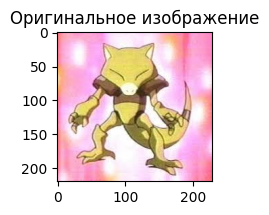

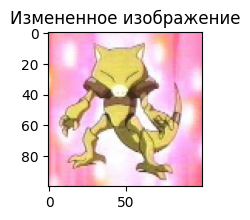

In [ ]:
for cls in os.listdir(DATA_PATH):
    cls_path = os.path.join(DATA_PATH, cls)
    for img_name in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(2, 2))
        plt.imshow(img)
        plt.title("Оригинальное изображение")
        plt.show()

        stretch_near = cv2.resize(img, size, interpolation = cv2.INTER_LINEAR)

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(2, 2))
        plt.imshow(stretch_near)
        plt.title("Измененное изображение")
        plt.show()
        break
    break

Сохраним измененный датасет

In [ ]:
AUGMENTED_DATA_PATH = r'D:\ProgrammingPython\neural_networks\PokemonData_100'
if not os.path.exists(AUGMENTED_DATA_PATH):
    os.makedirs(AUGMENTED_DATA_PATH)

In [ ]:
# Изменяем все изображения в датасете, чтобы размер был (200, 200)
for cls in os.listdir(DATA_PATH):
    cls_path = os.path.join(DATA_PATH, cls)
    cls_aug_path = os.path.join(AUGMENTED_DATA_PATH, cls)
    if not os.path.exists(cls_aug_path):
        os.makedirs(cls_aug_path)
    os.chdir(cls_aug_path)
    for img_name in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_name)
        aug_img_path = os.path.join(cls_aug_path, cls)
        img = cv2.imread(img_path)

        stretch_near = cv2.resize(img, size, interpolation = cv2.INTER_LINEAR)
        cv2.imwrite(img_name, stretch_near)

In [ ]:
DATA_PATH = r'D:\ProgrammingPython\neural_networks\PokemonData_100'
classes = {n: cls for n,cls in enumerate(os.listdir(DATA_PATH))}
classes_invert = {value:key for key, value in classes.items() }

class PokemonDataset(Dataset):

    def __init__(self, rootdir, transform) -> None:
        super().__init__()
        self.class_names = os.listdir(rootdir)
        self.class_idx = [i for i in range(len(self.class_names))]
        self.transform = transform
        self.images_pathes = []
        self.images_clas_names = []

        for cls_name in self.class_names:
            sub_root = os.path.join(rootdir, cls_name)
            self.images_pathes.extend(glob.glob(os.path.join(sub_root, '*.jpg')))
            self.images_clas_names.append(cls_name)

        random.shuffle(self.images_pathes)

    def __len__(self):
        return len(self.images_pathes)

    def __getitem__(self, index) -> tuple:

        img_path = self.images_pathes[index]
        image = cv2.imread(img_path)
        img_folder_pth = os.path.split(img_path)[0]
        cls_name = os.path.split(img_folder_pth)[-1]
        label = self.class_names.index(cls_name)

        if self.transform:
            image = self.transform(image)

        return (image, label)

In [ ]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean = 0.5, std = 0.5)
    ]
)

In [ ]:
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split

Оригинальный датасет не разделен на тренировочную и тестовую выборки, поэтому разделим датасет в соотношении 80 на 20

In [ ]:
TEST_SIZE = 0.2
BATCH_SIZE = 64
SEED = 42

In [ ]:
dataset = PokemonDataset(DATA_PATH, transform)

In [ ]:
generator = torch.Generator().manual_seed(SEED)

train_dataset, test_dataset = random_split(dataset, [1-TEST_SIZE, TEST_SIZE], generator=generator)

In [ ]:
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
for x,y in train_loader:
    print(x.shape)
    print(y)
    break


torch.Size([64, 3, 100, 100])
tensor([ 12,  20,  77,   8, 113,  79, 115, 143,  22,  13,  30,  79, 135, 114,
         81, 135, 126,  46,  52,  68,  23,  88,  17,   0, 112,  38, 111,  11,
         52,  76,  88,  91,  97,  54,  23,  92,  30,  88,  87,  34,  34,  96,
        141,  85, 112,  29, 129,  27,  29, 142, 125, 133,  81,  24,  87,  30,
        104, 118, 104,  37, 133,  24, 112,  29])


## Модель

In [ ]:
# выход с последнего слоя
print(f"Кол-во классов: {len(classes.values())}")

Кол-во классов: 150


In [ ]:
print(229//2)

114


Напишем полносвязную нейронную сеть классификатор

In [ ]:
class PokemonClassificator(nn.Module):
    def __init__(self):
        super(PokemonClassificator, self).__init__()
        self.linear_1 = nn.Linear(30000, 1024)
        self.linear_2 = nn.Linear(1024, 150)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)

        x = self.linear_1(x)
        x = F.tanh(x)
        x = self.linear_2(x)

        return x

In [ ]:
model = PokemonClassificator()
model.to(device)
loss_function = torch.nn.CrossEntropyLoss()

optimizator = torch.optim.Adam(model.parameters(), lr=0.001,)

In [ ]:
def val(model, test_loader):
    model.eval()
    tp = 0
    total = 0

    for x,y in test_loader:
        y = y.to(device)
        pred = torch.argmax(model(x.to(device)), dim=1)
        tp += int((pred == y).sum().to('cpu'))
        total +=len(pred)

    return tp/total

def train(dataloader, model, loss_fn, op_fn, epoch):
    acc = 0
    for ep in range(epoch):
        for step, (x, y) in enumerate(dataloader):


            y_pred = model(x.to(device))
            loss = loss_fn(y_pred.to(device), y.to(device))

            op_fn.zero_grad()
            loss.backward()
            op_fn.step()

            if step%100 == 0:
                loss, current = loss.item(), (ep+1)*(step+1)*BATCH_SIZE
                print(f"loss = {loss}, samples = {current}")

        acc = val(model, test_loader)
        print('precision =', acc)


    return acc


In [ ]:
accuracy = train(train_loader, model, loss_function, optimizator, 5)

loss = 5.085155963897705, samples = 64
loss = 4.166268825531006, samples = 6464
precision = 0.1179564237415477
loss = 3.4160711765289307, samples = 128
loss = 3.588920831680298, samples = 12928
precision = 0.19008264462809918
loss = 3.218522787094116, samples = 192
loss = 3.223994255065918, samples = 19392
precision = 0.24117205108940645
loss = 2.9955897331237793, samples = 256
loss = 2.935734987258911, samples = 25856
precision = 0.2787377911344853
loss = 2.8631253242492676, samples = 320
loss = 2.7942025661468506, samples = 32320
precision = 0.32156273478587527


Сохраним модель, указав датасет, кол-во эпох и точность

In [ ]:
accuracy = (accuracy*100)
output_str = f"fullyConnected_pokemon_100_classifier_5_{accuracy:.2f}"
output_str = output_str.replace(".", "_")
output_str = output_str + '.pt'
print(output_str)

fullyConnected_pokemon_100_classifier_5_32_16.pt


In [ ]:
torch.save(model, output_str)

## Оценка модели

In [ ]:
model.to('cpu')
model(x).size()

torch.Size([64, 150])

In [ ]:
model.eval()

PokemonClassificator(
  (linear_1): Linear(in_features=30000, out_features=1024, bias=True)
  (linear_2): Linear(in_features=1024, out_features=150, bias=True)
)

In [ ]:
predicts = []
labels = []

for x,y in test_loader:
    y = y.to('cpu').numpy()
    pred = torch.argmax(model(x.to('cpu')), dim=1).to('cpu').numpy()
    predicts.append(pred)
    labels.append(y)

print(len(predicts))


21


Посмотрим ответы модели

С помощью num_in_batch выбираем картинку в первом batch

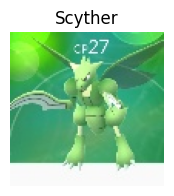

Истинная метка: 119 - Scyther
Предсказ метка: 119 - Scyther


In [ ]:
num_in_batch = 1
for x,y in test_loader:
    img = (x[num_in_batch].numpy().transpose(1, 2, 0) + 1) / 2
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(2, 2))
    plt.axis('off')
    plt.imshow((img*255).astype('int32'))
    plt.title(classes[int(y[num_in_batch])])
    plt.show()
    print(f'Истинная метка: {y[num_in_batch].numpy()} - {classes[int(y[num_in_batch])]}')
    print(f'Предсказ метка: {predicts[0][num_in_batch]} - {classes[int(predicts[0][num_in_batch])]}')
    break

In [ ]:
predicts = np.concatenate(predicts)
labels = np.concatenate(labels)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
cm = confusion_matrix(labels, predicts, labels=tuple(classes.keys()))


In [ ]:
cm.shape

(150, 150)

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

Выведем часть матрицы ошибок (5, 5), так как 150 на 150 матрица ошибок слишком большая

In [ ]:
plt.figure(figsize=(100, 100))
plt.rcParams.update({'font.size': 48})
plot_confusion_matrix(cm[:5,:5], tuple(classes.values())[:5])

C:\Users\Professional\AppData\Local\Temp\ipykernel_7492\3410106984.py:57: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


In [ ]:
plt.figure(figsize=(80, 80))
plt.rcParams.update({'font.size': 9})
plot_confusion_matrix(cm, tuple(classes.values()))